In [1]:
import deeplake
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# load GTZAN dataset
ds = deeplake.load("hub://activeloop/gtzan-genre")

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



/

hub://activeloop/gtzan-genre loaded successfully.



In [3]:
def audio_to_melspectrogram(audio_tensor, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # convert tensor to numpy array
    audio_array = audio_tensor.numpy()
    
    # compute mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert to decibels
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db

def audio_to_mfcc(audio_tensor, sr=22050, n_fft=2048, hop_length=512, n_mfcc=30):
    # convert tensor to numpy array
    audio_array = audio_tensor.numpy()
    
    # compute mel spectrogram
    mfcc = librosa.feature.mfcc(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
    return mfcc

In [4]:
def genre_tensor_to_string(genre):
    # map number to genre name
    number_genre_map = {0:"Pop", 1:"Metal", 2:"Classical", 3:"Rock", 4:"Blues", 5:"Jazz",
                        6:"Hip-hop", 7:"Reggae", 8:"Disco", 9:"Country"}
    
    genre_number = genre.numpy()[0]

    return number_genre_map[genre_number]

In [5]:
def plot_spectrogram(spectrogram, genre):
    # display spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram of {genre_tensor_to_string(genre).lower()} song')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

In [6]:
# create list of spectrograms
spectrograms = []

for i, audio_tensor in enumerate(ds["audio"]):
    spectrograms.append(audio_to_melspectrogram(audio_tensor))

In [7]:
# create list of mfcc values for each song
mfccs = []

for i, audio_tensor in enumerate(ds["audio"]):
    mfccs.append(audio_to_mfcc(audio_tensor))

In [11]:
# create list of tuple containing spectrogram and genre
spectrograms_with_genre = []
genre_labels = []

for i, spectrogram in enumerate(spectrograms):
    spectrograms_with_genre.append((spectrogram, ds["genre"][i]))
    genre_labels.append(ds["genre"][i].numpy())

In [10]:
def pad_numpy_columns(numpy_arrs, target_number=2000):
    # Pad each spectrogram to have the target number of columns
    padded_numpy_arrs = []
    for arr in numpy_arrs:
        num_columns_to_pad = target_number - arr.shape[1]
        if num_columns_to_pad > 0:
            # Pad with zeros to the right (after the spectrogram)
            padded_arr = np.pad(arr, ((0, 0), (0, num_columns_to_pad)), mode='constant')
        else:
            # No padding needed
            padded_arr = arr
        padded_numpy_arrs.append(padded_arr)
    
    return padded_numpy_arrs

In [24]:
padded_spectrograms = pad_numpy_columns(spectrograms, target_number=1320)
padded_mfccs = pad_numpy_columns(mfccs, target_number=1320)

In [29]:
spectrograms_flat = [spec.flatten() for spec in padded_spectrograms]
x1_train, x1_test, y1_train, y1_test = train_test_split(spectrograms_flat, genre_labels, test_size=0.2, random_state=42)
knn_model_spectrograms = KNeighborsClassifier(n_neighbors=5)
knn_model_spectrograms.fit(x1_train, y1_train)

c:\Users\lwolf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [30]:
mfccs_flat = [mfcc.flatten() for mfcc in padded_mfccs]
x2_train, x2_test, y2_train, y2_test = train_test_split(mfccs_flat, genre_labels, test_size=0.2, random_state=42)
knn_model_mfccs = KNeighborsClassifier(n_neighbors=5)
knn_model_mfccs.fit(x2_train, y2_train)

c:\Users\lwolf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [33]:
y1_pred = knn_model_spectrograms.predict(x1_test)

accuracy = accuracy_score(y1_test, y1_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.295


In [34]:
y2_pred = knn_model_mfccs.predict(x2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.32


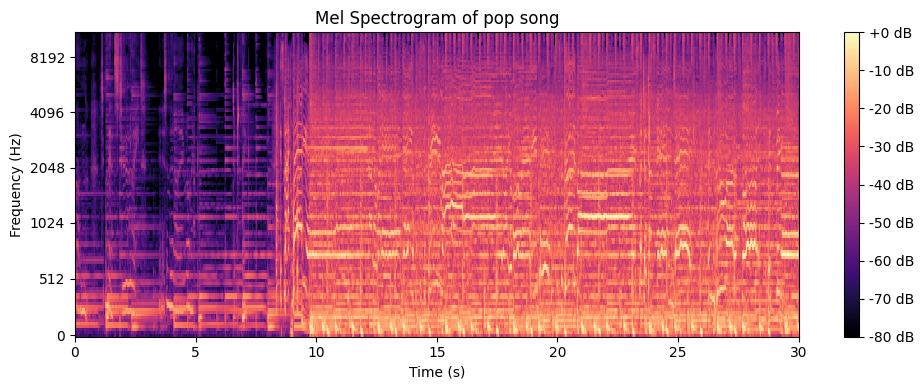

In [35]:
# example of plotted spectrogram

plot_spectrogram(spectrograms_with_genre[0][0], spectrograms_with_genre[0][1])